### Imports

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import matrixprofile
from matrixprofile.discord
from tslearn.clustering import TimeSeriesKMeans, KShape
from tslearn.generators import random_walks
from tslearn.piecewise import PiecewiseAggregateApproximation
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN
import zlib
from tensorflow.keras.optimizers import Adagrad
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict

from tslearn.preprocessing import TimeSeriesScalerMinMax
from pyts.classification import LearningShapelets

# 1. Prepare Time Series Dataset

In [7]:
dataset = pd.read_csv("data/final_dataset.csv")
print("Shape of dataset:", dataset.shape)
dataset.head()

Shape of dataset: (239381, 77)


,date,year,city_or_county,latitude,longitude,min_age_participants,avg_age_participants,max_age_participants,teen_ratio,adults_ratio,...,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,month_x,month_y
0,729.0,2015.0,Indianapolis,39.8322,-86.2492,19.0,19.0,19.0,0.0,1.0,...,False,False,False,False,False,False,False,False,5.000000e-01,-0.866025
1,1459.0,2017.0,Kane,41.6645,-78.7856,62.0,62.0,62.0,0.0,1.0,...,False,False,False,False,False,False,False,False,8.660254e-01,-0.500000
2,1404.0,2016.0,Detroit,42.4190,-83.0393,19.0,19.0,19.0,0.0,1.0,...,False,False,False,False,False,False,False,False,-5.000000e-01,0.866025
3,1383.0,2016.0,Washington,38.9030,-76.9820,21.0,21.0,21.0,0.0,1.0,...,False,False,False,False,False,False,False,False,-8.660254e-01,0.500000
4,894.0,2015.0,Pittsburgh,40.4621,-80.0308,21.0,21.0,21.0,0.0,1.0,...,False,False,False,False,False,False,False,False,1.224647e-16,-1.000000


## 1.1 Select cities

In [8]:
dataset['year'].value_counts()

year
2017.0    61389
2016.0    58724
2015.0    53335
2014.0    51684
2018.0    13801
2013.0      448
Name: count, dtype: int64

Keep only incidents regarding [2014, 2015, 2016, 2017], as by project assignment instructions.

In [9]:
dataset = dataset[(dataset['year'] > 2013) & (dataset['year'] < 2018)]

Analysis of cities reveals that many cities are present with different names, resulting in incorrect city value counts.

In [10]:
with open('debugging/cities.txt', 'w') as f:
    for item in dataset['city_or_county'].unique():
        f.write("%s\n" % item)
        
# Write city and value counts of each city to a file
with open('debugging/city_counts.txt', 'w') as f:
    f.write(dataset['city_or_county'].value_counts().to_string())

print('There are {} unique cities in the dataset'.format(len(dataset['city_or_county'].unique())))
        

There are 12596 unique cities in the dataset


Eliminate parenthesis with county or extra information.

In [11]:
# Eliminate all data between parenthesis in the city column using re module
dataset['city_or_county'] = dataset['city_or_county'].apply(lambda x: re.sub(r"\(.*\)", "", x))
print('There are {} unique cities in the dataset'.format(len(dataset['city_or_county'].unique())))

There are 11762 unique cities in the dataset


Sort cities alphabetically to see if there are still duplicates and how relevant they are.

In [12]:
# Get all cities and sort them alphabetically and write them in a file
cities = dataset['city_or_county'].unique()
cities.sort()
with open('debugging/cities2.txt', 'w') as f:
    for item in cities:
        f.write("%s\n" % item)

We can see that there are many cities which differ in having a space in the end, let's remove all spaces to avoid problems.

In [13]:
# Remove all spaces from city names
dataset['city_or_county'] = dataset['city_or_county'].apply(lambda x: x.replace(" ", ""))
print('There are {} unique cities in the dataset'.format(len(dataset['city_or_county'].unique())))

There are 10416 unique cities in the dataset


In [14]:
dataset['city_or_county'] = dataset['city_or_county'].str.upper()
print('There are {} unique cities in the dataset'.format(len(dataset['city_or_county'].unique())))

There are 10331 unique cities in the dataset


Introducing a week parameter and filtering only cities with a number of weeks with incidents greater than 15% of the total number of the weeks of the 4 years.

In [15]:
dataset['week'] = " "

# Date attribute is a progressive integer number, starting from 0
# Assign a week number to each date
dataset['date'] = dataset['date'] - dataset['date'].min()
dataset['week'] = dataset['date'].apply(lambda x: int(x / 7))

n_weeks = dataset['week'].max()
n_weeks

208

In [17]:
cities = dataset['city_or_county'].unique()
dropping_threshold = 0.15

for city in cities:
    city_data = dataset[dataset['city_or_county'] == city]
    city_weeks_with_incidents = city_data['week'].nunique()

    # Drop the city if it has less than 15% of the weeks with incidents
    if city_weeks_with_incidents < n_weeks * dropping_threshold:
        dataset = dataset[dataset['city_or_county'] != city]

print('Number of cities for which time series will be generated:', dataset['city_or_county'].nunique())
dataset.head()

Number of cities for which time series will be generated: 713


,date,year,city_or_county,latitude,longitude,min_age_participants,avg_age_participants,max_age_participants,teen_ratio,adults_ratio,...,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,month_x,month_y,week
0,364.0,2015.0,INDIANAPOLIS,39.8322,-86.2492,19.0,19.0,19.0,0.0,1.0,...,False,False,False,False,False,False,False,5.000000e-01,-8.660254e-01,52
2,1039.0,2016.0,DETROIT,42.4190,-83.0393,19.0,19.0,19.0,0.0,1.0,...,False,False,False,False,False,False,False,-5.000000e-01,8.660254e-01,148
3,1018.0,2016.0,WASHINGTON,38.9030,-76.9820,21.0,21.0,21.0,0.0,1.0,...,False,False,False,False,False,False,False,-8.660254e-01,5.000000e-01,145
4,529.0,2015.0,PITTSBURGH,40.4621,-80.0308,21.0,21.0,21.0,0.0,1.0,...,False,False,False,False,False,False,False,1.224647e-16,-1.000000e+00,75
7,805.0,2016.0,NEWHAVEN,41.2945,-72.9457,20.0,20.0,20.0,1.0,0.0,...,False,False,False,False,False,False,False,1.000000e+00,6.123234e-17,115


## 1.2 Score functions for subtasks

Define the functions to compute the score for each of the two subtasks

In [20]:
def compute_week_score(week_data, task):
    # Compute the score for a given week, to be used in the time series
    match task:
        case 'task1':
            score = (week_data['killed_ratio'] * week_data['n_participants']).sum()
        case _:
            raise ValueError('Task not recognized')
    return score

def generate_time_series(city_data, n_weeks, task):
    # Generate the time series for a given city
    time_series = np.zeros(n_weeks)
    for week in range(n_weeks):
        week_data = city_data[city_data['week'] == week]
        if week_data.shape[0] > 0:
            time_series[week] = compute_week_score(week_data, task)
    return time_series

def generate_time_series_dataset(dataset, task):
    # Generate the time series for all cities
    n_weeks = dataset['week'].max()
    cities = dataset['city_or_county'].unique()
    time_series = []
    for city in cities:
        city_data = dataset[dataset['city_or_county'] == city]
        time_series.append(generate_time_series(city_data, n_weeks, task))
    return np.array(time_series)

# 2. Clustering

## 2.1 Generate time series

In [21]:
ts_dataset = generate_time_series_dataset(dataset, 'task1')
ts_dataset.shape

(713, 208)

In [22]:
X = ts_dataset

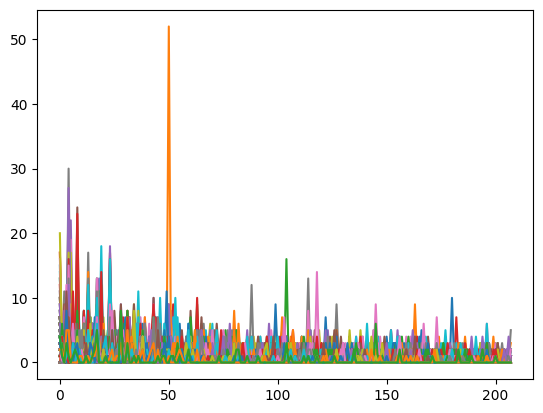

In [23]:
plt.plot(X.reshape(X.shape[1], X.shape[0]))
plt.show()

### 2.1.1 Time series scaling / ... ????

## 2.2 Shape-Based Clustering 

### 2.2.1 KMeans with Euclidean Distance

In [24]:
km = TimeSeriesKMeans(n_clusters=5, metric="euclidean", max_iter=10, random_state=0)
km.fit(X)

TimeSeriesKMeans(max_iter=10, n_clusters=5, random_state=0)

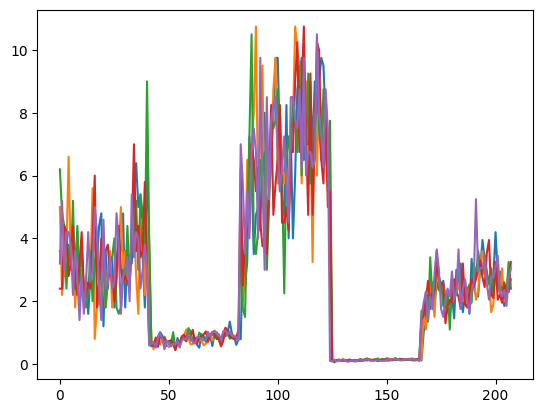

In [25]:
plt.plot(km.cluster_centers_.reshape(X.shape[1], 5))
plt.show()

### 2.2.1 KMeans with DTW

In [26]:
km_dtw = TimeSeriesKMeans(n_clusters=5, metric="dtw", max_iter=5, random_state=0)
km_dtw.fit(X)

TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=5, random_state=0)

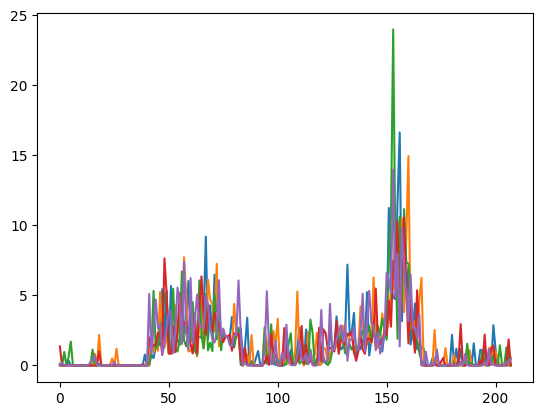

In [27]:
plt.plot(km_dtw.cluster_centers_.reshape(X.shape[1], 5))
plt.show()

### 2.2.1 KShape

In [31]:
ks = KShape(n_clusters=5, n_init=1, random_state=0).fit(X)
ks.cluster_centers_.shape

(5, 208, 1)

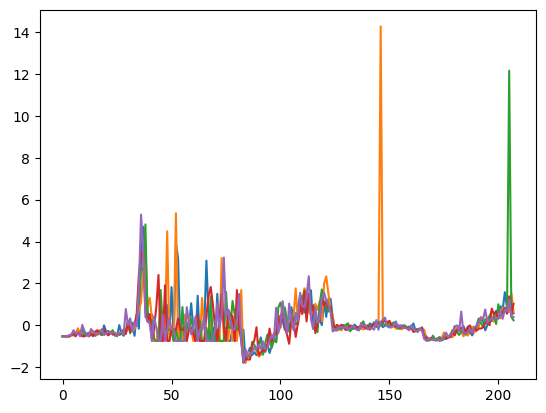

In [32]:
plt.plot(ks.cluster_centers_.reshape(X.shape[1], 5))
plt.show()

## 2.3 Feature-Based Clustering

In [33]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [34]:
F = [list(calculate_features(x).values())[:-2] for x in X]

In [35]:
kmeans = KMeans(n_clusters=5, n_init=10)
kmeans.fit(F)

KMeans(n_clusters=5, n_init=10)

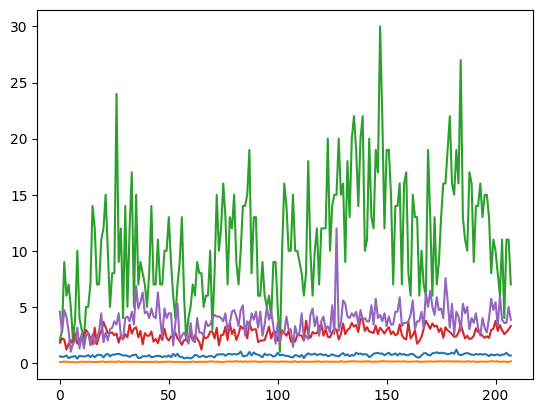

In [36]:
for i in range(5):
    plt.plot(np.mean(X[np.where(kmeans.labels_ == i)[0]], axis=0))
plt.show()

In [37]:
kmeans.inertia_

621.1322847890509

## 2.4 Compression-based clustering

In [38]:
def cdm_dist(x, y):
    x_str = (' '.join([str(v) for v in x.ravel()])).encode('utf-8')
    y_str = (' '.join([str(v) for v in y.ravel()])).encode('utf-8')
    return len(zlib.compress(x_str + y_str)) / (len(zlib.compress(x_str)) + len(zlib.compress(y_str)))

In [39]:
M = pairwise_distances(X.reshape(X.shape[0], X.shape[1]), metric=cdm_dist)
M

array([[0.55027933, 0.87338501, 0.9010989 , ..., 0.94594595, 0.95631068,
        0.95391705],
       [0.87338501, 0.54567308, 0.89312977, ..., 0.95219124, 0.96595745,
        0.95528455],
       [0.9010989 , 0.89312977, 0.54864865, ..., 0.95175439, 0.96226415,
        0.95515695],
       ...,
       [0.94594595, 0.95219124, 0.95175439, ..., 0.68604651, 0.82857143,
        0.86419753],
       [0.95631068, 0.96595745, 0.96226415, ..., 0.82857143, 0.72222222,
        0.83076923],
       [0.95391705, 0.95528455, 0.95515695, ..., 0.86419753, 0.83076923,
        0.67105263]])

In [40]:
dbscan = DBSCAN(eps=0.965, min_samples=5, metric='precomputed')
dbscan.fit(M)

DBSCAN(eps=0.965, metric='precomputed')

In [41]:
n_paa_segments = 10
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
X_paa = paa.fit_transform(X)

/Users/dre/Desktop/GitRepo/Others/DataMiningProject/venv/lib/python3.10/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 713 1-dimensional timeseries
  warnings.warn(


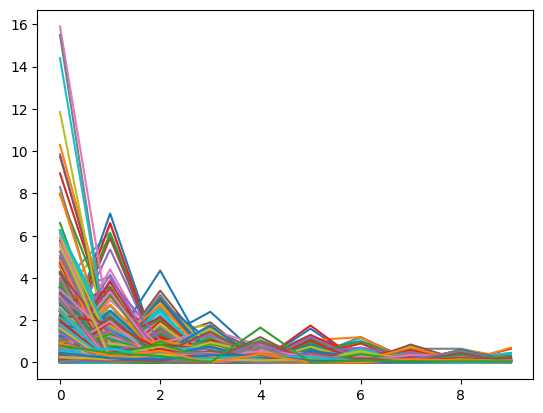

In [42]:
plt.plot(X_paa.reshape(X_paa.shape[1], X_paa.shape[0]))
plt.show()

In [43]:
km = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=5, random_state=0)
km.fit(X_paa)

TimeSeriesKMeans(max_iter=5, random_state=0)

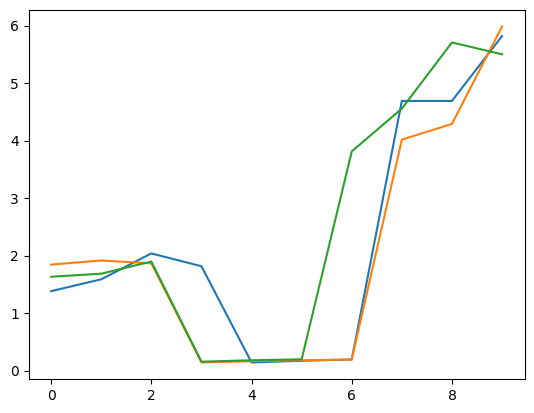

In [44]:
plt.plot(km.cluster_centers_.reshape(X_paa.shape[1], 3))
plt.show()

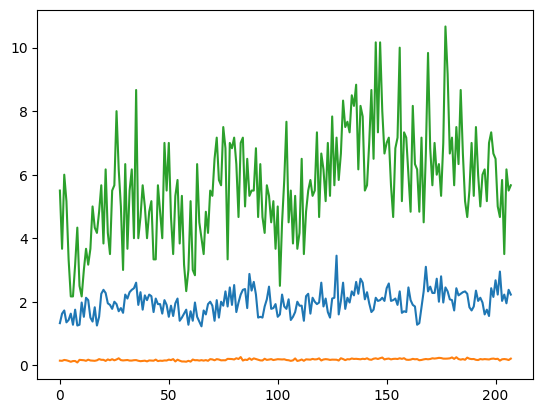

In [45]:
for i in range(3):
    plt.plot(np.mean(X[np.where(km.labels_ == i)[0]], axis=0))
plt.show()

# 3. Motif Extraction

In [ ]:
w = 12
mp, mpi = matrixProfile.stomp(ts.values, w)

plt.plot(mp)
plt.show()

In [ ]:
w = 3
mp, mpi = matrixProfile.stomp(ts.values, w)

plt.plot(mp)
plt.show()

In [ ]:
mo, mod  = motifs.motifs(ts.values, (mp, mpi), max_motifs=5)

In [ ]:
plt.plot(ts.values)
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo)]
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = ts.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.show()

In [ ]:
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = ts.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)
    plt.show()

# 4. Anomaly Detection

# 5. Shapelet Extraction

In [46]:
n_ts, ts_sz = X.shape
n_classes = len(set(y))


shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

NameError: name 'y' is not defined

In [ ]:
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=.01,
                        max_iter=200,
                        verbose=1)

In [ ]:
from sklearn.metrics import accuracy_score
predicted_labels = shp_clf.predict(X)
print("Correct classification rate:", accuracy_score(y, predicted_labels))
predicted_locations = shp_clf.locate(X)

In [ ]:
ts_id = 0
plt.figure()
n_shapelets = sum(shapelet_sizes.values())
plt.title(f"""Example locations of shapelet matches ({n_shapelets} shapelets extracted)""")

plt.plot(X[ts_id].ravel())
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)

In [ ]:
from pyts.transformation import ShapeletTransform
st = ShapeletTransform(n_shapelets=5, window_sizes=[8])
st.fit(X, y)

In [ ]:
print(len(st.shapelets))
st.shapelets_

In [ ]:
for s in st.shapelets_:
    plt.plot(s)

plt.show()

In [ ]:
st.indices_

In [ ]:
st.scores_

Shapelets + classification

In [ ]:
shp_clf = LearningShapelets(random_state=42, tol=0.01)

In [ ]:
shp_clf.fit(X, y)

In [ ]:
shp_clf.coef_.shape

In [ ]:
# Select three shapelets
sel_shapelets = np.asarray([shp_clf.shapelets_[0, 0], 
                        shp_clf.shapelets_[0, 1], 
                        shp_clf.shapelets_[0, 2]])

In [ ]:
plt.plot(sel_shapelets[0])
plt.plot(sel_shapelets[1])
plt.plot(sel_shapelets[2])

plt.show()